<a href="https://colab.research.google.com/github/Chaganti-Reddy/EVMarket-India/blob/main/EVMarket_India.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from collections import Counter
from sklearn import metrics
import statsmodels.api as sm

## Read the data

In [124]:

data = pd.read_csv('data.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data['inr(10e3)'] = data['PriceEuro']*0.08320
data['RapidCharge'].replace(to_replace=['No','Yes'],value=[0, 1],inplace=True)
data.head()


,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro,inr(10e3)
0,Tesla,Model 3 Long Range Dual Motor,4.6000,233,450,161,940,1,AWD,Type 2 CCS,Sedan,D,5,55480,4615.9360
1,Volkswagen,ID.3 Pure,10.0000,160,270,167,250,0,RWD,Type 2 CCS,Hatchback,C,5,30000,2496.0000
2,Polestar,2,4.7000,210,400,181,620,1,AWD,Type 2 CCS,Liftback,D,5,56440,4695.8080
3,BMW,iX3,6.8000,180,360,206,560,1,RWD,Type 2 CCS,SUV,D,5,68040,5660.9280
4,Honda,e,9.5000,145,170,168,190,1,RWD,Type 2 CCS,Hatchback,B,4,32997,2745.3504


In [125]:
print("\nMissing values in each column:")
print(data.isnull().sum())

data.dropna(inplace=True)

categorical_columns = ['Brand', 'Model', 'PowerTrain', 'PlugType', 'BodyStyle', 'Segment', 'RapidCharge']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

numerical_columns = ['AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm', 'FastCharge_KmH', 'Seats', 'PriceEuro']
scaler = StandardScaler()
data_encoded[numerical_columns] = scaler.fit_transform(data_encoded[numerical_columns])

print("\nFirst few rows of the preprocessed dataset:")
print(data_encoded.head())



Missing values in each column:
Brand              0
Model              0
AccelSec           0
TopSpeed_KmH       0
Range_Km           0
Efficiency_WhKm    0
FastCharge_KmH     0
RapidCharge        0
PowerTrain         0
PlugType           0
BodyStyle          0
Segment            0
Seats              0
PriceEuro          0
inr(10e3)          0
dtype: int64

First few rows of the preprocessed dataset:
   AccelSec  TopSpeed_KmH  Range_Km  Efficiency_WhKm  FastCharge_KmH   Seats  \
0   -0.9312        1.2409    0.8869          -0.9572          2.4425  0.1471   
1    0.8672       -0.4427   -0.5485          -0.7533         -0.9572  0.1471   
2   -0.8979        0.7105    0.4881          -0.2775          0.8658  0.1471   
3   -0.1985        0.0186    0.1692           0.5722          0.5702  0.1471   
4    0.7007       -0.7886   -1.3460          -0.7193         -1.2528 -1.1156   

   PriceEuro  inr(10e3)  Brand_Audi   Brand_BMW   ...  BodyStyle_Sedan  \
0    -0.0098  4615.9360        False    

## Information of the type of data in seach column

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            103 non-null    object 
 1   Model            103 non-null    object 
 2   AccelSec         103 non-null    float64
 3   TopSpeed_KmH     103 non-null    int64  
 4   Range_Km         103 non-null    int64  
 5   Efficiency_WhKm  103 non-null    int64  
 6   FastCharge_KmH   103 non-null    int64  
 7   RapidCharge      103 non-null    int64  
 8   PowerTrain       103 non-null    object 
 9   PlugType         103 non-null    object 
 10  BodyStyle        103 non-null    object 
 11  Segment          103 non-null    object 
 12  Seats            103 non-null    int64  
 13  PriceEuro        103 non-null    int64  
 14  inr(10e3)        103 non-null    float64
dtypes: float64(2), int64(7), object(6)
memory usage: 12.2+ KB


## Descriptive Statistics of the dataset

In [127]:
data.describe()

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,Seats,PriceEuro,inr(10e3)
count,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000
mean,7.3961,179.1942,338.7864,189.1650,444.2718,0.7476,4.8835,55811.5631,4643.5221
std,3.0174,43.5730,126.0144,29.5668,203.9493,0.4365,0.7958,34134.6653,2840.0042
min,2.1000,123.0000,95.0000,104.0000,170.0000,0.0000,2.0000,20129.0000,1674.7328
25%,5.1000,150.0000,250.0000,168.0000,260.0000,0.5000,5.0000,34429.5000,2864.5344
50%,7.3000,160.0000,340.0000,180.0000,440.0000,1.0000,5.0000,45000.0000,3744.0000
75%,9.0000,200.0000,400.0000,203.0000,555.0000,1.0000,5.0000,65000.0000,5408.0000
max,22.4000,410.0000,970.0000,273.0000,940.0000,1.0000,7.0000,215000.0000,17888.0000


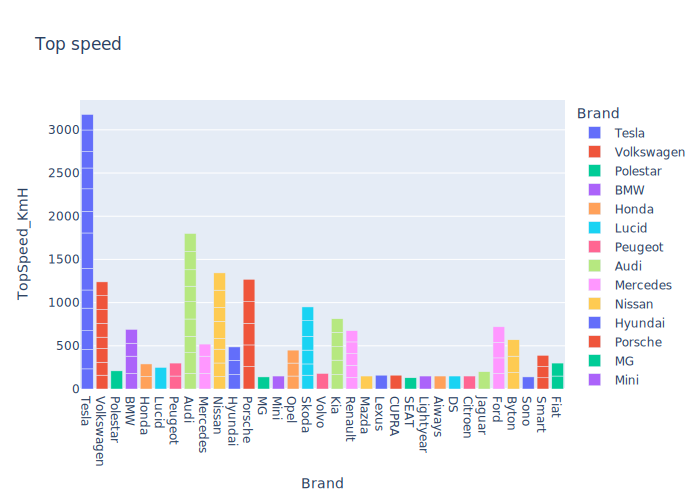

In [128]:
fig = px.bar(data,x='Brand',y = 'TopSpeed_KmH',color = 'Brand',title = 'Top speed',labels = {'x':'Car Brands','y':'Top Speed Km/H'})
fig.show()

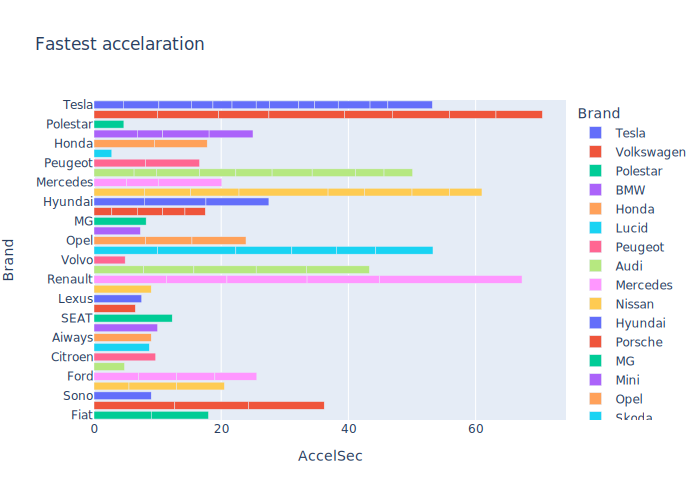

In [129]:
fig = px.bar(data,x='AccelSec',y = 'Brand',color = 'Brand',title = 'Fastest accelaration',labels = {'x':'Accelaration','y':'Car Brands'})
fig.show()

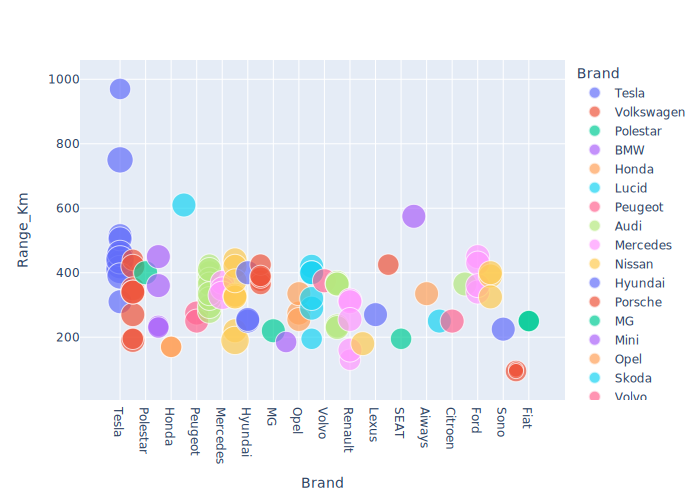

In [130]:
fig = px.scatter(data,x = 'Brand',y = 'Range_Km',size='Seats',color = 'Brand',hover_data=['RapidCharge','inr(10e3)'])
fig.show()

## Heatmap to show the correlation of the data

Correlation matrix:
                 AccelSec  TopSpeed_KmH  Range_Km  Efficiency_WhKm  \
AccelSec           1.0000       -0.7862   -0.6771          -0.3829   
TopSpeed_KmH      -0.7862        1.0000    0.7467           0.3557   
Range_Km          -0.6771        0.7467    1.0000           0.3131   
Efficiency_WhKm   -0.3829        0.3557    0.3131           1.0000   
FastCharge_KmH    -0.7336        0.7852    0.7237           0.3219   
Seats             -0.1753        0.1265    0.3002           0.3012   
PriceEuro         -0.6272        0.8291    0.6748           0.3967   

                 FastCharge_KmH   Seats  PriceEuro  
AccelSec                -0.7336 -0.1753    -0.6272  
TopSpeed_KmH             0.7852  0.1265     0.8291  
Range_Km                 0.7237  0.3002     0.6748  
Efficiency_WhKm          0.3219  0.3012     0.3967  
FastCharge_KmH           1.0000  0.1934     0.6679  
Seats                    0.1934  1.0000     0.0209  
PriceEuro                0.6679  0.0209     1.00

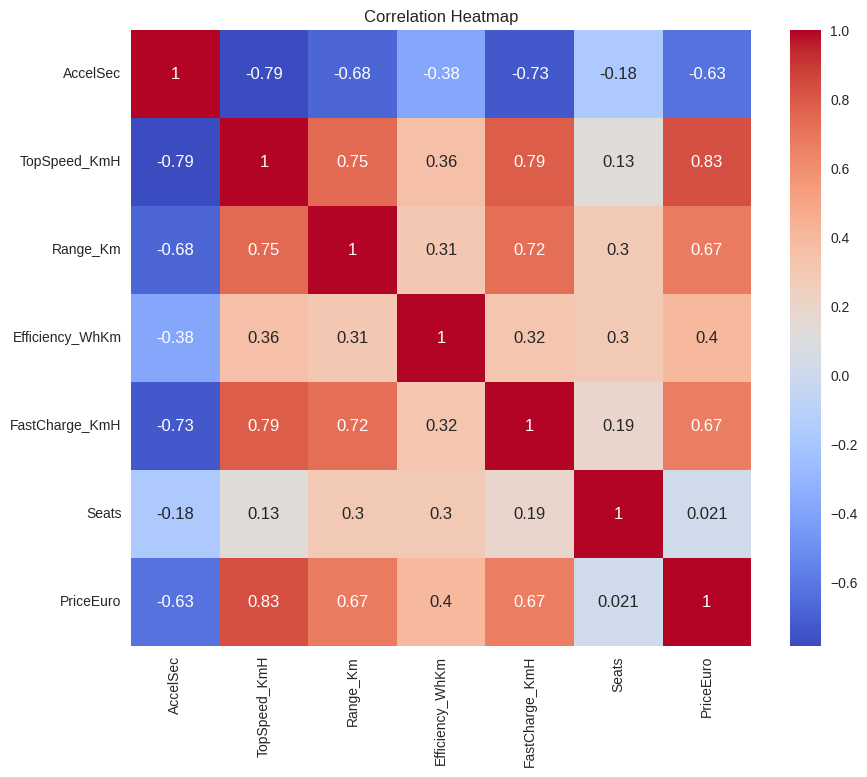

In [131]:
# Select only numerical columns for correlation matrix
numerical_columns = ['AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm', 'FastCharge_KmH', 'Seats', 'PriceEuro']
data_numeric = data_encoded[numerical_columns]

# Calculate the correlation matrix
correlation_matrix = data_numeric.corr()

# Display the correlation matrix
print("Correlation matrix:")
print(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Making Some Comparisions for our dataset


## Frequency of the Brands in the dataset

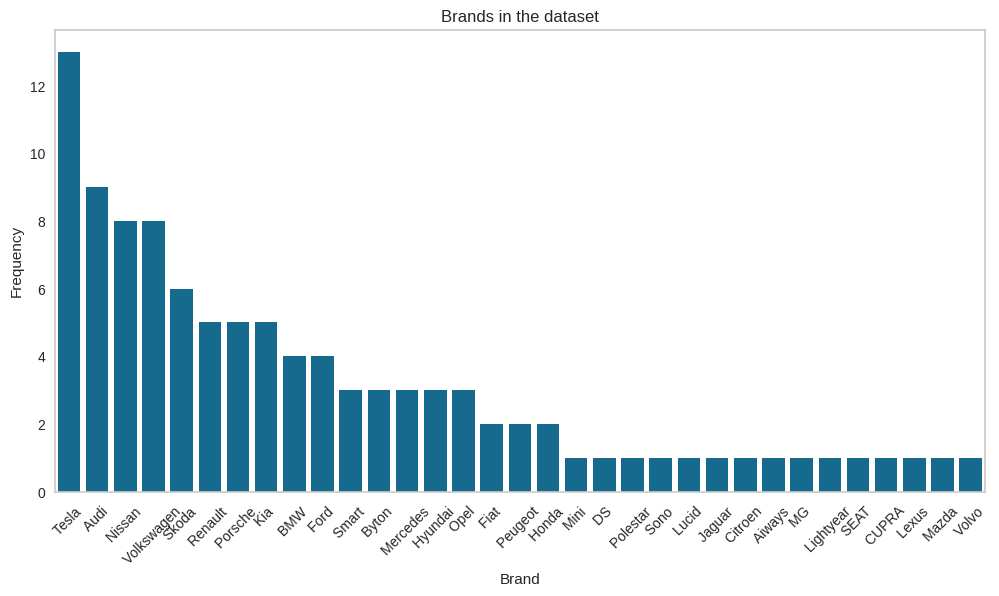

In [132]:
brand_counts = data['Brand'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Frequency']

plt.figure(figsize=(12, 6))

sb.barplot(x='Brand', y='Frequency', data=brand_counts)
plt.grid(axis='y')
plt.title('Brands in the dataset')
plt.xlabel('Brand')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Tesla, audi and nissan were some of the most frequently occuring in the dataset

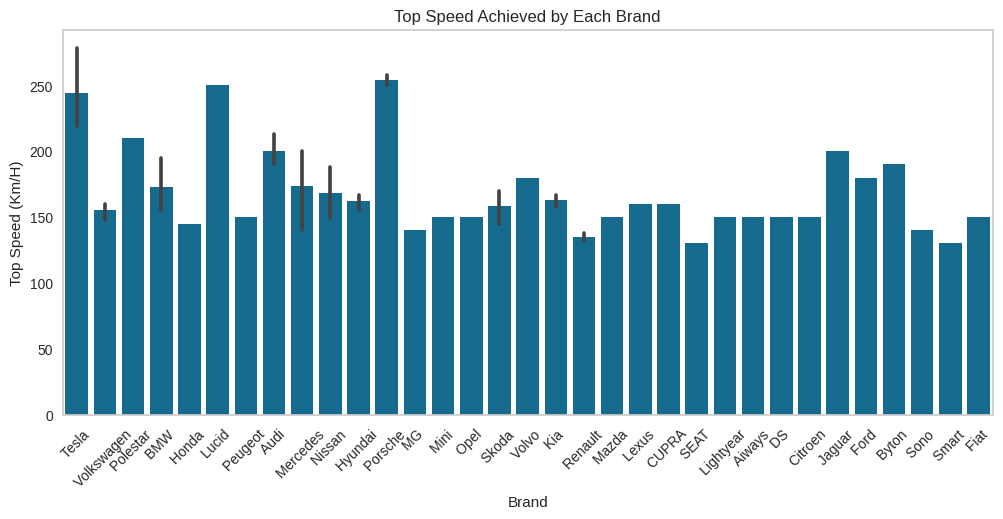

In [133]:
plt.figure(figsize=(12, 5))
sb.barplot(x='Brand', y='TopSpeed_KmH', data=data)
plt.grid(axis='y')
plt.title('Top Speed Achieved by Each Brand')
plt.xlabel('Brand')
plt.ylabel('Top Speed (Km/H)')
plt.xticks(rotation=45)

plt.show()

Porsche, Lucid and Tesla are the fastest producing cars and Smart the lowest





## Range a car can achieve

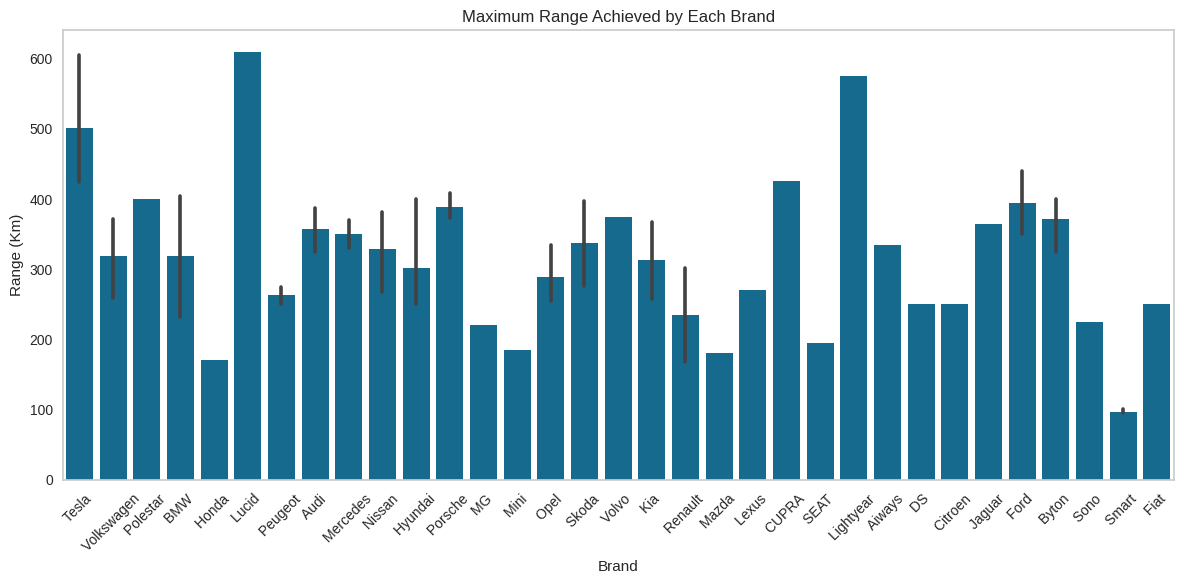

In [134]:
plt.figure(figsize=(12, 6))
sb.barplot(x='Brand', y='Range_Km', data=data)
plt.grid(axis='y')
plt.title('Maximum Range Achieved by Each Brand')
plt.xlabel('Brand')
plt.ylabel('Range (Km)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Lucid, Lightyear and Tesla cover the highest range while Smart covers the lowest range.


## Car efficiency

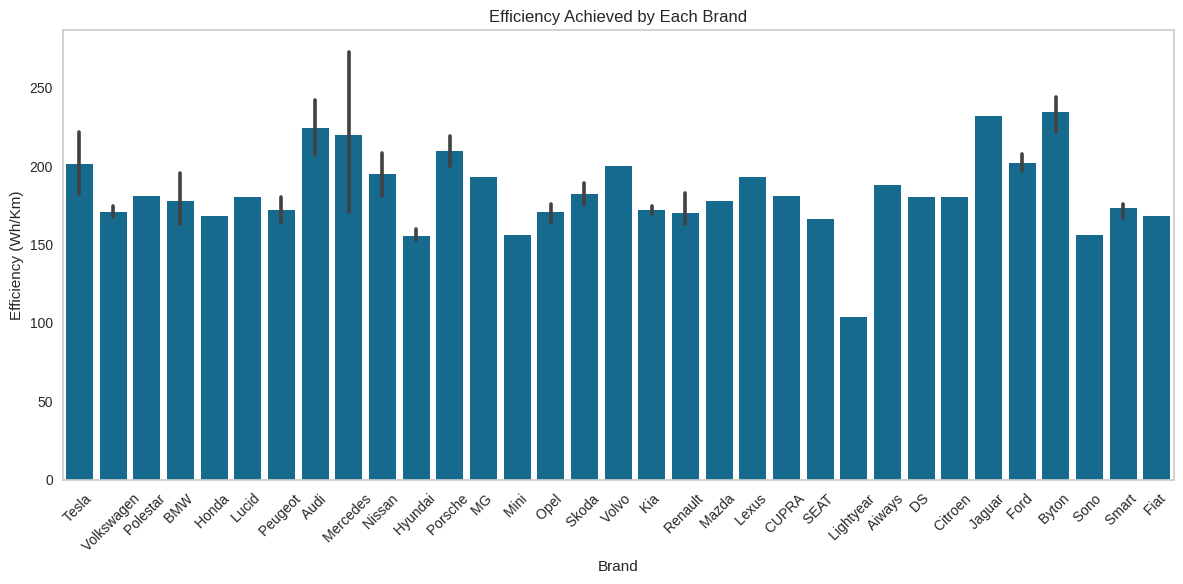

In [135]:
plt.figure(figsize=(12, 6))
sb.barplot(x='Brand', y='Efficiency_WhKm', data=data)
plt.grid(axis='y')
plt.title('Efficiency Achieved by Each Brand')
plt.xlabel('Brand')
plt.ylabel('Efficiency (Wh/Km)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Byton , Jaguar and Audi are the most efficient and Lightyear the least

## Number of seats in each car

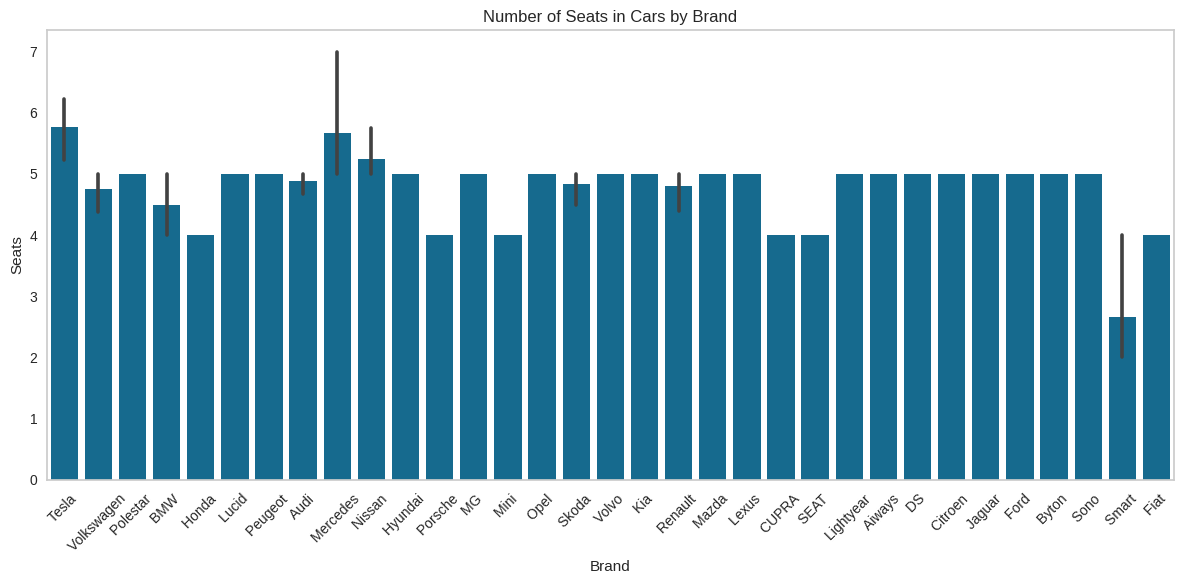

In [136]:
plt.figure(figsize=(12, 6))
sb.barplot(x='Brand', y='Seats', data=data)
plt.grid(axis='y')
plt.title('Number of Seats in Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Seats')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Mercedes, Tesla and Nissan have the highest number of seats and Smart the lowest

## Price of cars (in INR)

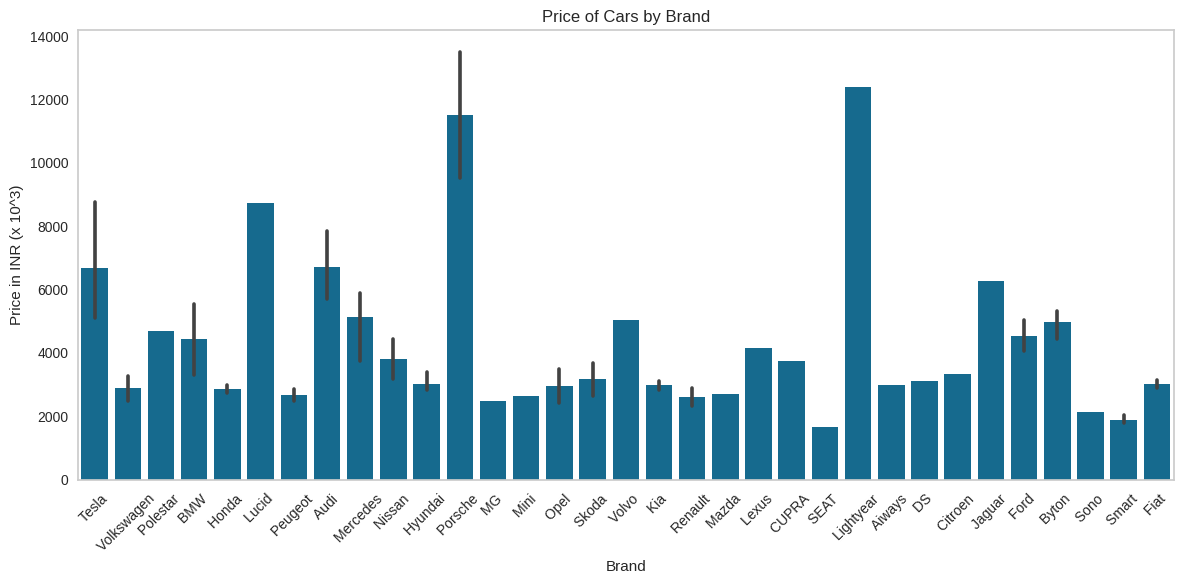

In [137]:
plt.figure(figsize=(12, 6))
sb.barplot(x='Brand', y='inr(10e3)', data=data)
plt.title('Price of Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Price in INR (x 10^3)')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

\Lightyear, Porsche and Lucid are the most expensive, while SEAT and Smart the least

## Type of Plug used for charging

Text(0.5, 1.0, 'Plug Type')

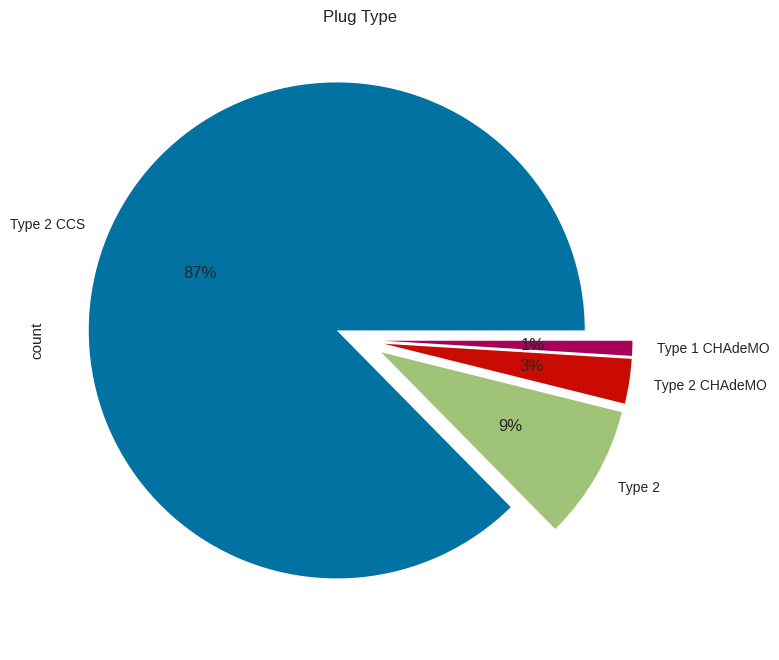

In [138]:
data['PlugType'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(.1,.1,.1,.1))
plt.title('Plug Type')

Most companies use Type 2 CCS and Type 1 CHAdeMo the least

## Cars and their body style

Text(0.5, 1.0, 'Body Style')

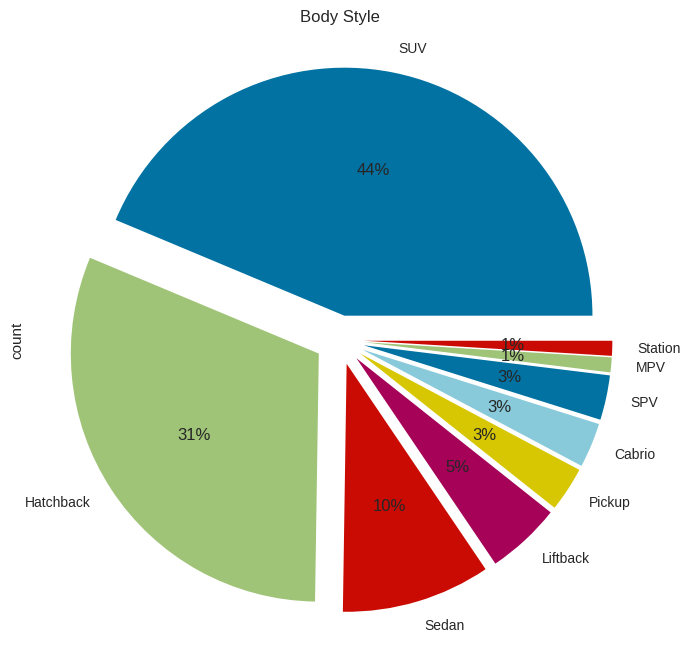

In [139]:
data['BodyStyle'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1))
plt.title('Body Style')

Most cars are eiher SUV or Hatchback

## Segment in which the cars fall under

Text(0.5, 1.0, 'Segment')

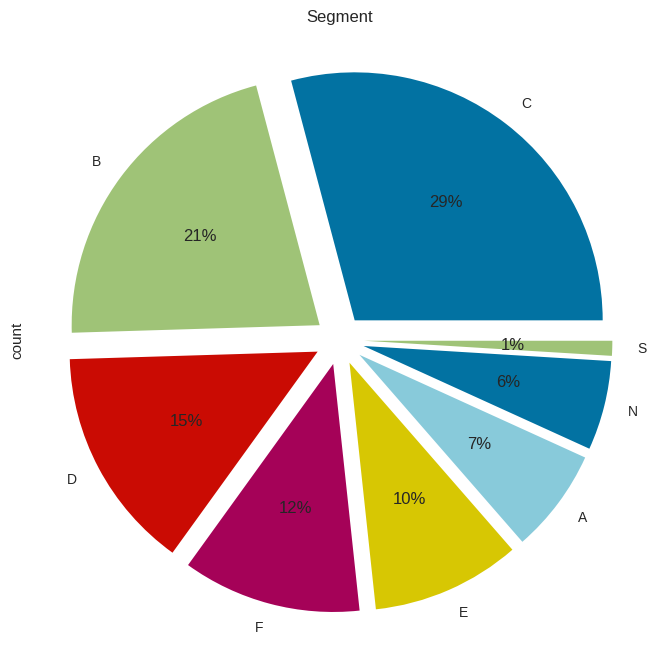

In [140]:
data['Segment'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1))
plt.title('Segment')

Most cars are either C or B type

## Number of Seats

Text(0.5, 1.0, 'Seats')

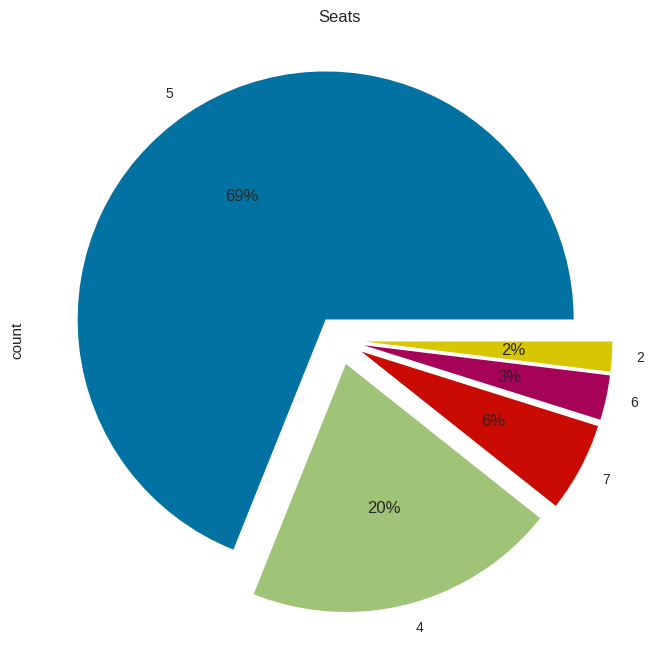

In [141]:
data['Seats'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(0.1,0.1,0.1,0.1,0.1))
plt.title('Seats')

Majority of cars have 5 seats

In [142]:
df3= data[["TopSpeed_KmH", "inr(10e3)"]].groupby("TopSpeed_KmH").count()
df4= data[["Range_Km", "inr(10e3)"]].groupby("Range_Km").count()
df5= data[["Range_Km", "TopSpeed_KmH"]].groupby("Range_Km").count()
df5.head()

,TopSpeed_KmH
Range_Km,
95,2
100,1
130,1
160,1
170,2


In [143]:
df3=df3.sort_values("TopSpeed_KmH",ascending = False).head(10)
df4=df4.sort_values("Range_Km",ascending = False).head(10)
df5=df5.sort_values("Range_Km",ascending = False).head(10)

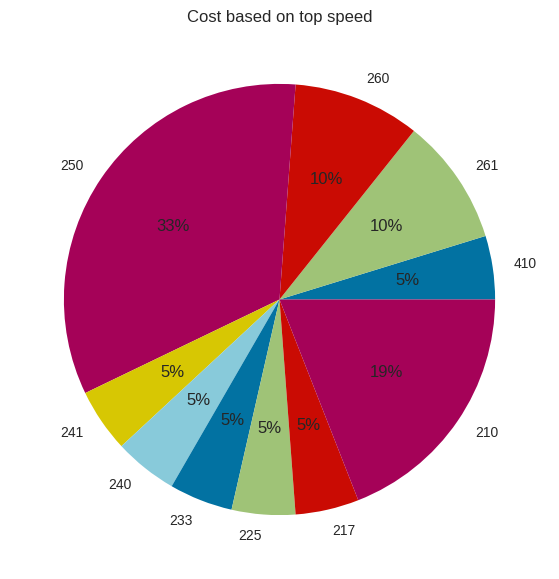

In [144]:
plt.figure(figsize=(10,7))
plt.title('Cost based on top speed')
plt.pie(x=df3["inr(10e3)"],labels=df3.index,autopct='%1.0f%%')
plt.show()

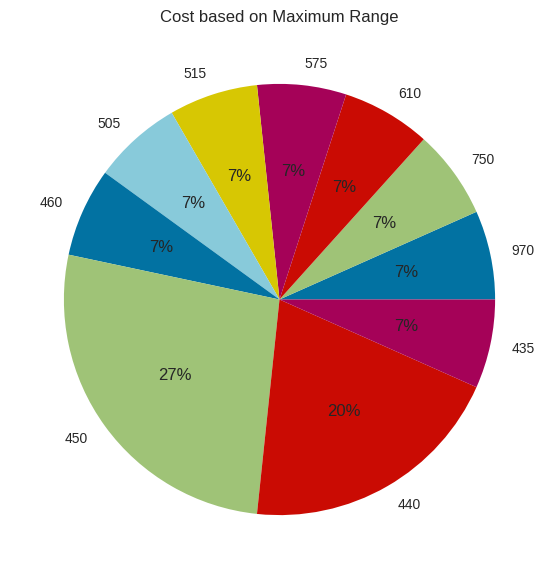

In [145]:
plt.figure(figsize=(10,7))
plt.title('Cost based on Maximum Range')
plt.pie(x=df4["inr(10e3)"],labels=df4.index,autopct='%1.0f%%')
plt.show()

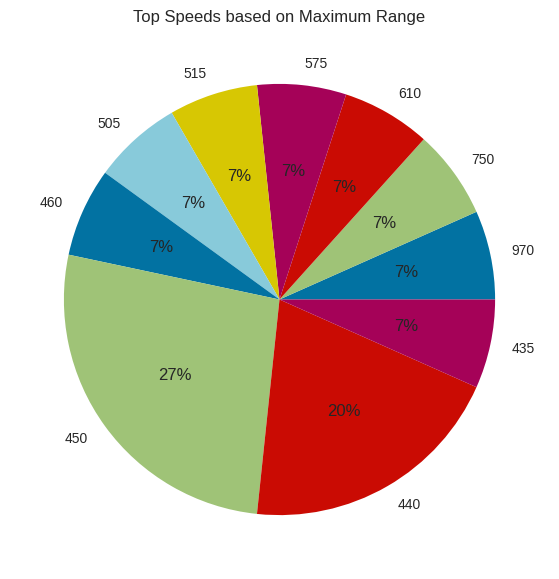

In [146]:
plt.figure(figsize=(10,7))
plt.title('Top Speeds based on Maximum Range')
plt.pie(x=df5["TopSpeed_KmH"],labels=df5.index,autopct='%1.0f%%')
plt.show()

# Regression

## Putting independent variables as x and dependent variable as y

In [147]:
data['PowerTrain'].replace(to_replace=['RWD','AWD','FWD'],value=[0, 2,1],inplace=True)
x=data[['AccelSec','Range_Km','TopSpeed_KmH','Efficiency_WhKm', 'RapidCharge','PowerTrain']]
y=data['PriceEuro']

## Finding out the linear regression using OLS method

In [148]:
x= sm.add_constant(x)
results = sm.OLS(y,x)

## Fitting the model and summarizing

In [149]:
model=results.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PriceEuro   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     41.36
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           1.57e-24
Time:                        15:33:10   Log-Likelihood:                -1155.0
No. Observations:                 103   AIC:                             2324.
Df Residuals:                      96   BIC:                             2342.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.031e+05   2.38e+04     -4.324      0.000    -1.5e+05   -5.58e+04
AccelSec         1753.0004   1048.759      1.672      0.098    -328.769    3834.770
Range_Km           36.3000     22.629      1.604      0.112      -8.618      81.218
TopSpeed_KmH      581.7484     80.158      7.257      0.000     422.636     740.861
Efficiency_WhKm   117.6685     70.307      1.674      0.097     -21.890     257.227
RapidCharge      1465.5687   4496.958      0.326      0.745   -7460.822    1.04e+04
PowerTrain       5235.8309   2956.235      1.771      0.080    -632.248    1.11e+04
==============================================================================
Omnibus:                       84.867   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              741.645
Skew:                           2.644   Prob(JB):                    8.99e-162
Kurtosis:                      15.036   Cond. No.                     5.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""



Only Top Speed and Efficieny are the two variables related to price

In [150]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=365)

In [151]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

## Finding out the R-squared value

In [152]:
r2 = r2_score(y_test, pred)
print(f"R-squared score: {r2 * 100:.2f}%")

R-squared score: 78.77%


Around 78% of the dependant variable has been explained by the independant variables

In [153]:
y1=data[['RapidCharge']]
x1=data[['PriceEuro']]

In [154]:
X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2,random_state=365)

In [155]:
log= LogisticRegression()
log.fit(X1_train, y1_train)
pred1 = log.predict(X1_test)
pred1

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Confusion Matrix of the regression

In [156]:
cm = confusion_matrix(y1_test, pred1)
cm

array([[ 0,  6],
       [ 0, 15]])

## Clustering

<Axes: xlabel='TopSpeed_KmH', ylabel='FastCharge_KmH'>

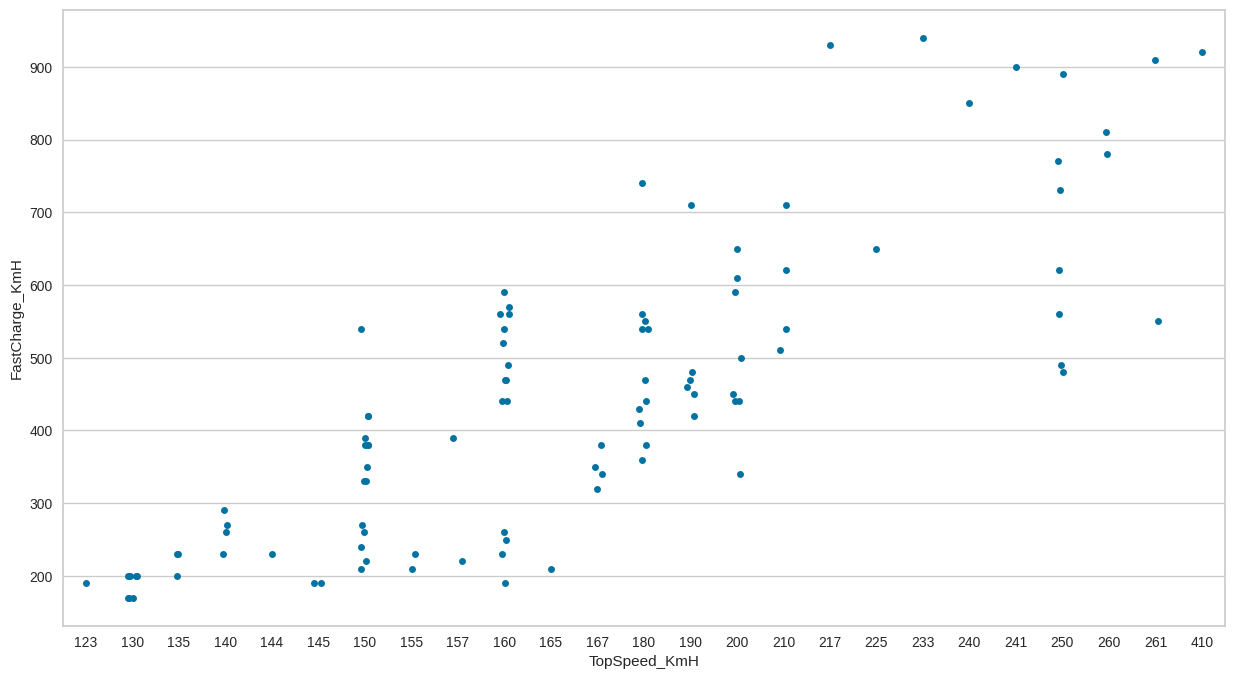

In [157]:
ax=plt.subplots(figsize=(15,8))
sb.stripplot(x='TopSpeed_KmH', y='FastCharge_KmH', data=data, jitter=True)

<Axes: xlabel='TopSpeed_KmH', ylabel='Efficiency_WhKm'>

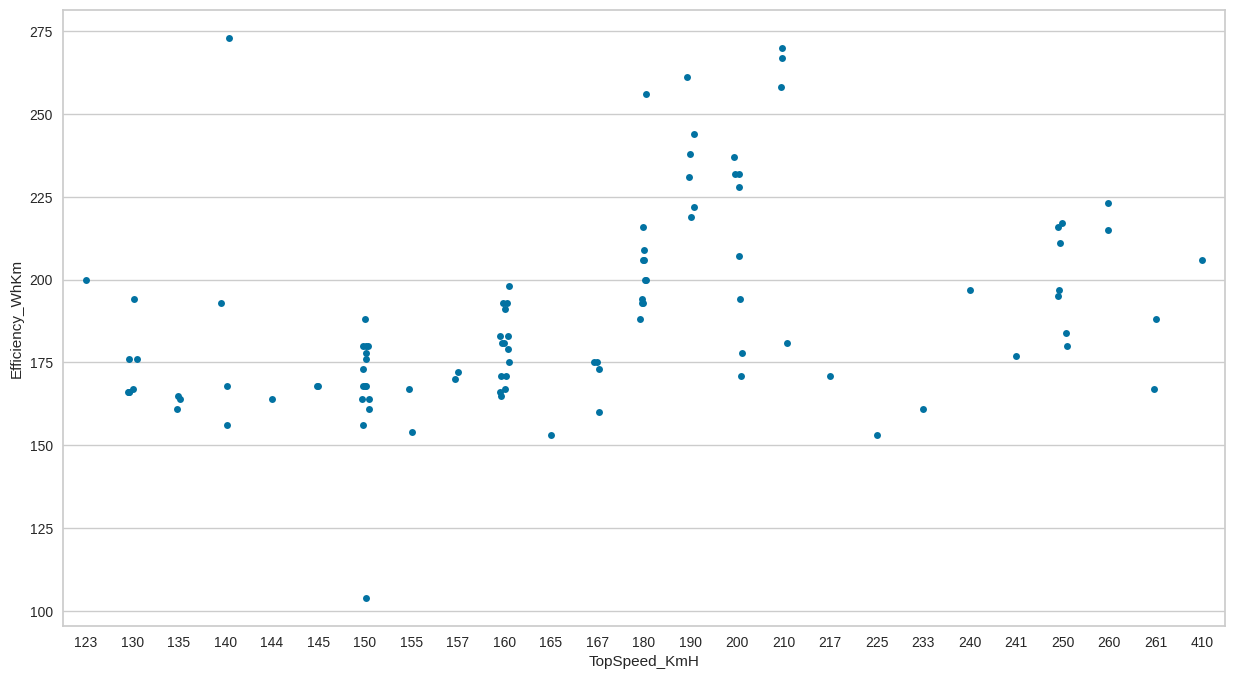

In [158]:
ax=plt.subplots(figsize=(15,8))
sb.stripplot(x='TopSpeed_KmH', y='Efficiency_WhKm', data=data, jitter=True)

In [159]:
features = ['AccelSec','TopSpeed_KmH','Efficiency_WhKm','FastCharge_KmH', 'RapidCharge','Range_Km', 'Seats', 'inr(10e3)','PowerTrain']
# Separating out the features
x = data.loc[:, features].values
x = StandardScaler().fit_transform(x)

In [160]:
pca = PCA(n_components=9)
t = pca.fit_transform(x)
data2 = pd.DataFrame(t, columns=['PC1', 'PC2','PC3','PC4','Pc5','PC6', 'PC7', 'PC8','PC9'])
data2

,PC1,PC2,PC3,PC4,Pc5,PC6,PC7,PC8,PC9
0,2.4292,-0.5546,-1.1478,-0.8828,0.8400,-0.9593,0.9989,0.7111,-0.3967
1,-2.3225,-0.3454,0.8965,-1.3055,0.0796,0.2351,-0.2137,-0.5441,-0.1819
2,1.5879,0.0089,-0.6505,0.0410,0.5935,-0.6982,0.0587,0.2488,-0.2028
3,0.2910,-0.0001,-0.3077,-0.5142,-1.6089,0.2916,0.3650,-0.2355,0.2617
4,-2.6027,-0.6265,-0.8881,0.5853,-0.8021,0.0274,-0.0850,-0.5078,-0.0499
...,...,...,...,...,...,...,...,...,...
98,-0.2972,0.4467,-0.4636,0.1025,-0.3460,-0.1005,0.0311,0.2023,0.1454
99,2.3350,0.6307,0.9859,1.5601,-0.8173,-0.1219,0.1641,-0.2557,0.1410
100,0.7806,0.4268,-0.2986,0.7086,0.4817,-0.5401,-0.1398,-0.0487,-0.3675
101,1.5409,0.6988,0.4224,1.0949,-0.2981,-0.3080,-0.3632,0.1273,-0.1904


In [161]:
df_9=data2.iloc[:,:9]
df_9.head(3)

,PC1,PC2,PC3,PC4,Pc5,PC6,PC7,PC8,PC9
0,2.4292,-0.5546,-1.1478,-0.8828,0.8400,-0.9593,0.9989,0.7111,-0.3967
1,-2.3225,-0.3454,0.8965,-1.3055,0.0796,0.2351,-0.2137,-0.5441,-0.1819
2,1.5879,0.0089,-0.6505,0.0410,0.5935,-0.6982,0.0587,0.2488,-0.2028


In [162]:
# correlation coefficient between original variables and the component
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_9.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning:

Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.



,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
variable,,,,,,,,,
PC1,-0.3964,0.0862,0.0648,0.0583,0.1445,0.6769,0.4125,0.2707,-0.3246
PC2,0.4220,-0.2168,0.0023,-0.0685,0.0382,0.0452,0.0376,-0.4138,-0.7708
PC3,0.2383,0.3309,0.5718,0.3805,-0.5751,0.0249,0.0047,0.1442,-0.0990
PC4,0.3945,-0.1384,-0.0477,-0.2965,-0.0924,-0.2379,0.7282,0.3584,0.1057
Pc5,0.1572,0.2699,-0.8033,0.3953,-0.2926,0.0870,0.0539,0.0408,-0.0561
PC6,0.3895,-0.0247,-0.0763,-0.3871,-0.0328,0.3645,-0.5208,0.5342,-0.0380
PC7,0.1404,0.8013,0.0195,-0.4290,0.1653,0.0867,0.0984,-0.3208,0.0800
PC8,0.3898,-0.2623,0.0738,0.1799,0.0433,0.5587,0.1180,-0.3821,0.5172
PC9,0.3229,0.1805,0.0983,0.4866,0.7228,-0.1499,-0.0191,0.2653,-0.0333


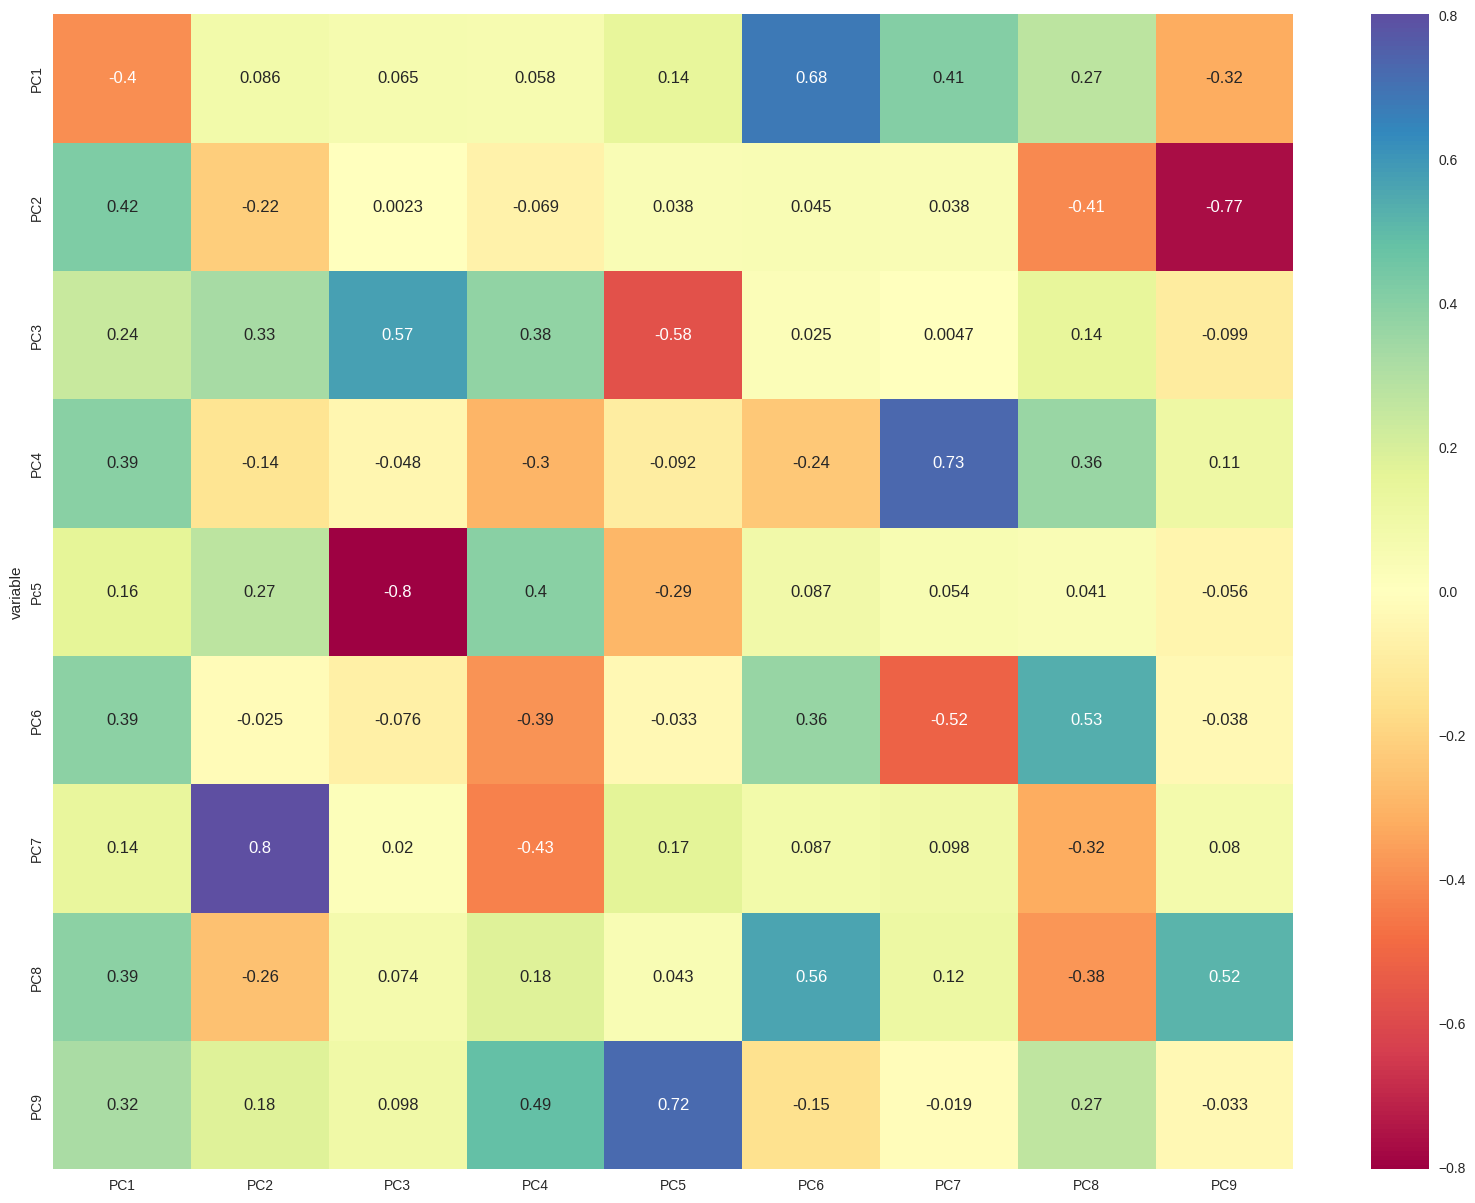

In [163]:
#Correlation matrix plot for loadings
plt.rcParams['figure.figsize'] = (20,15)
ax = sb.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

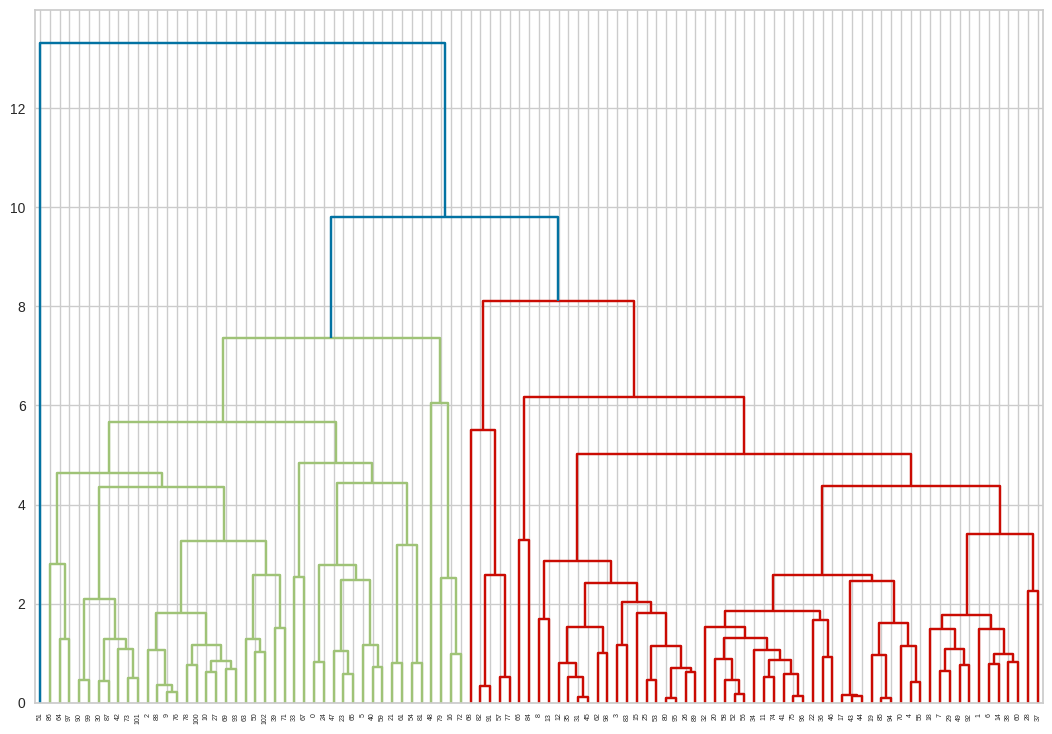

In [164]:
linked = linkage(data2, 'complete')
plt.figure(figsize=(13, 9))
dendrogram(linked, orientation='top')
plt.show()

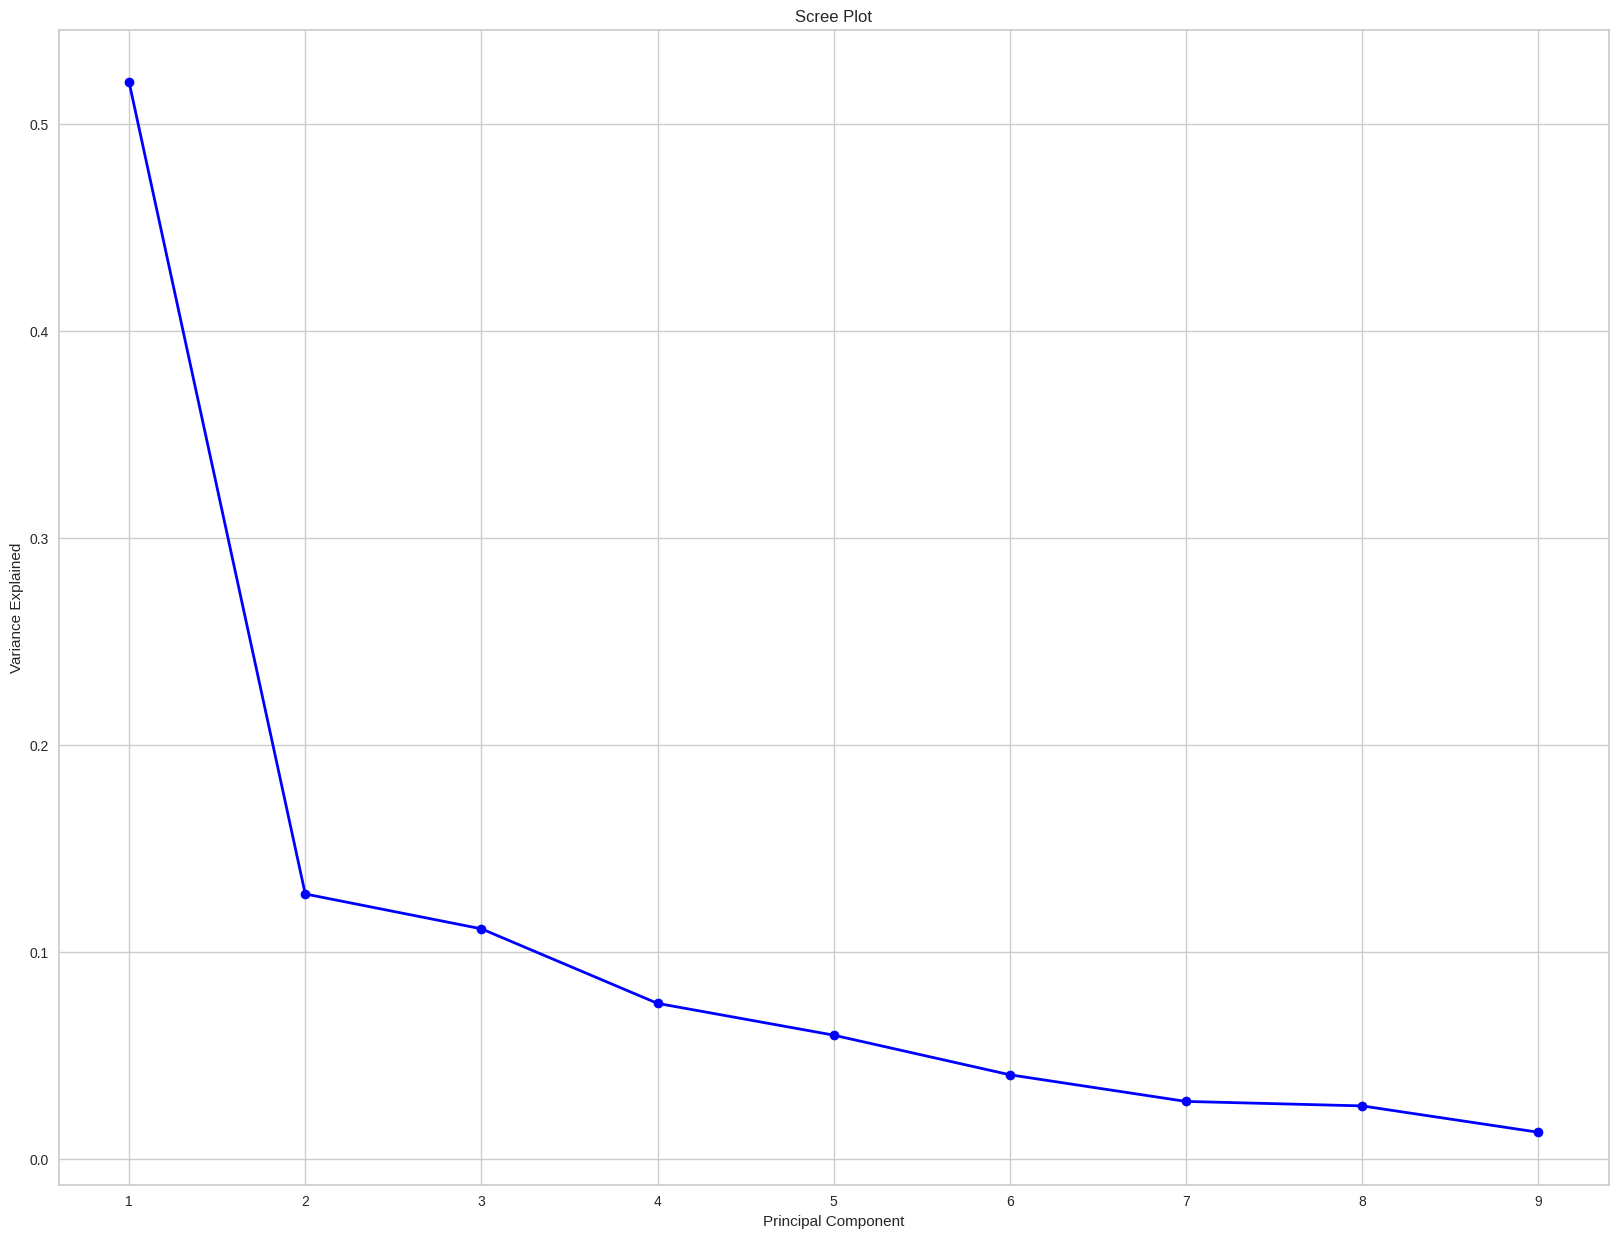

In [165]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

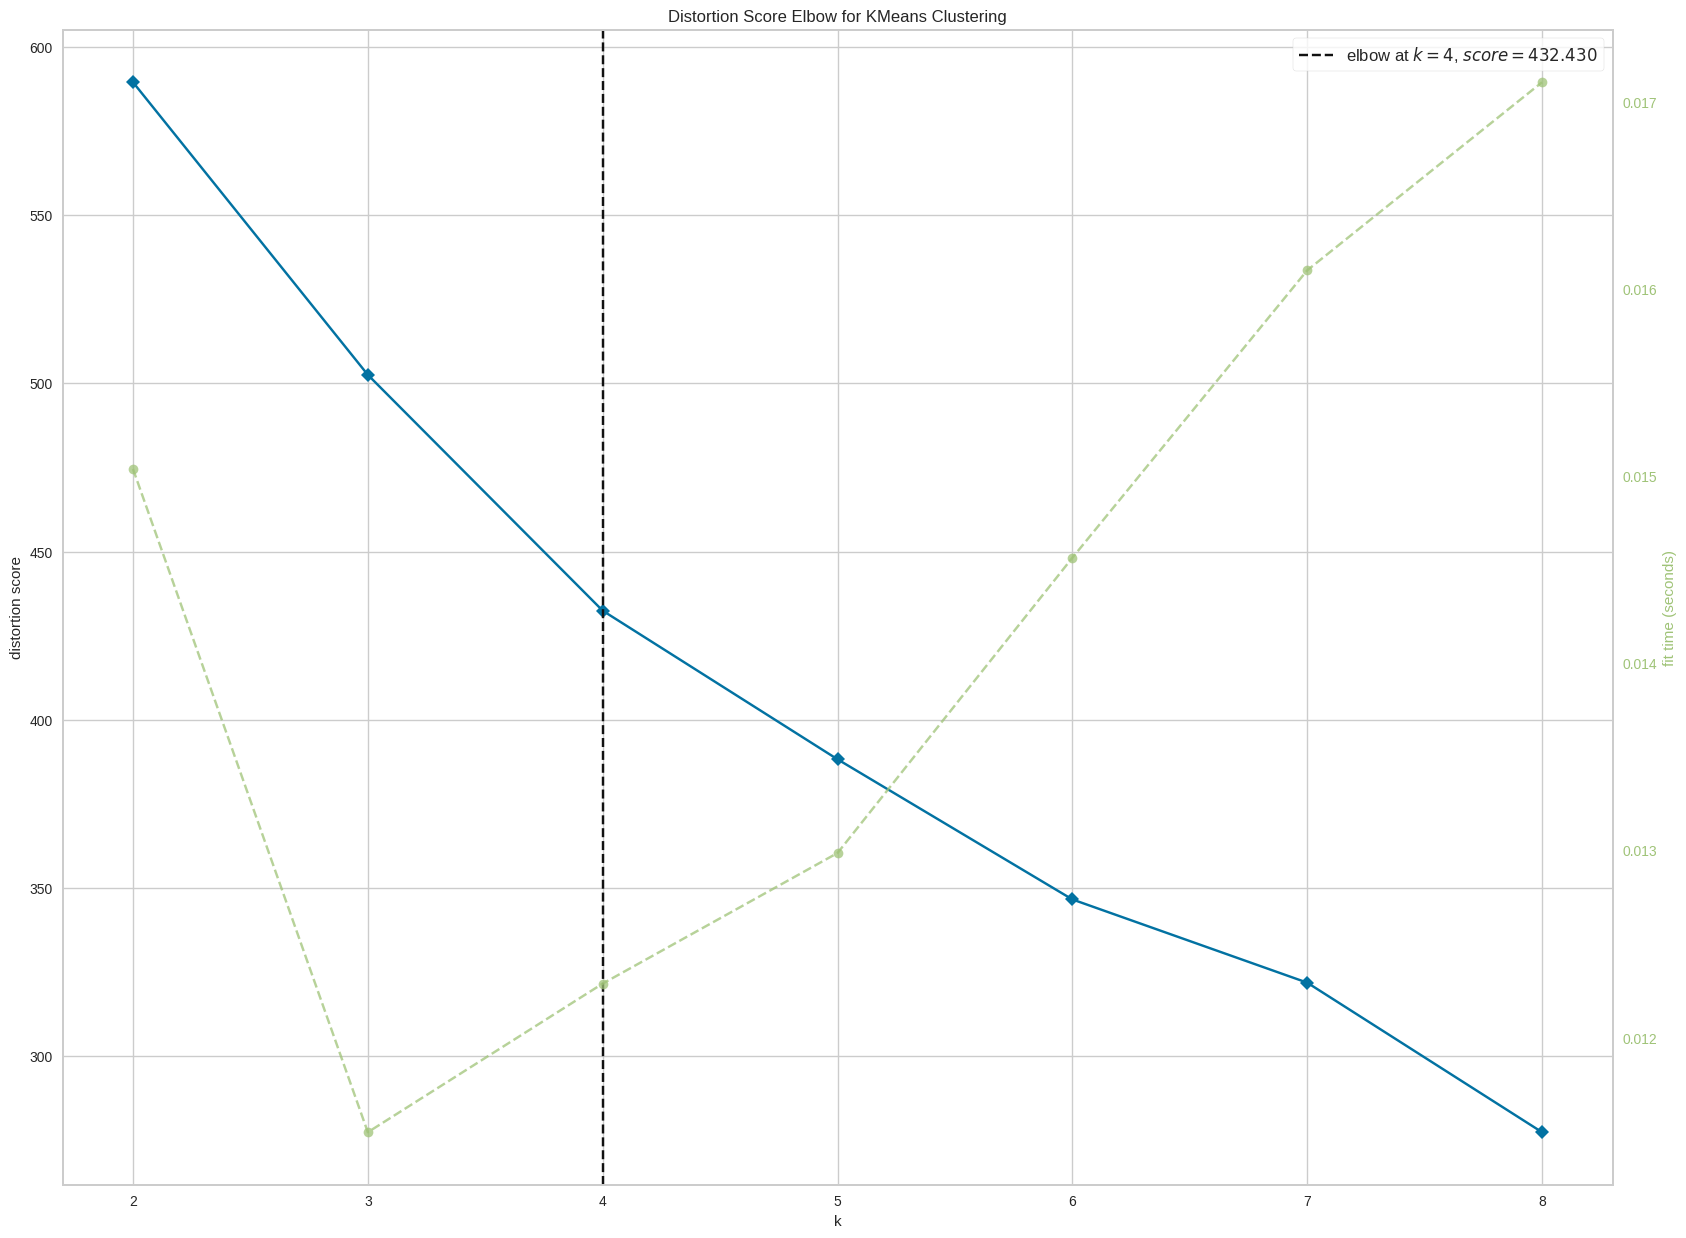

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [166]:
model = KMeans(random_state=40)
visualizer = KElbowVisualizer(model, k=(2,9), metric='distortion', timings=True)
visualizer.fit(t)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

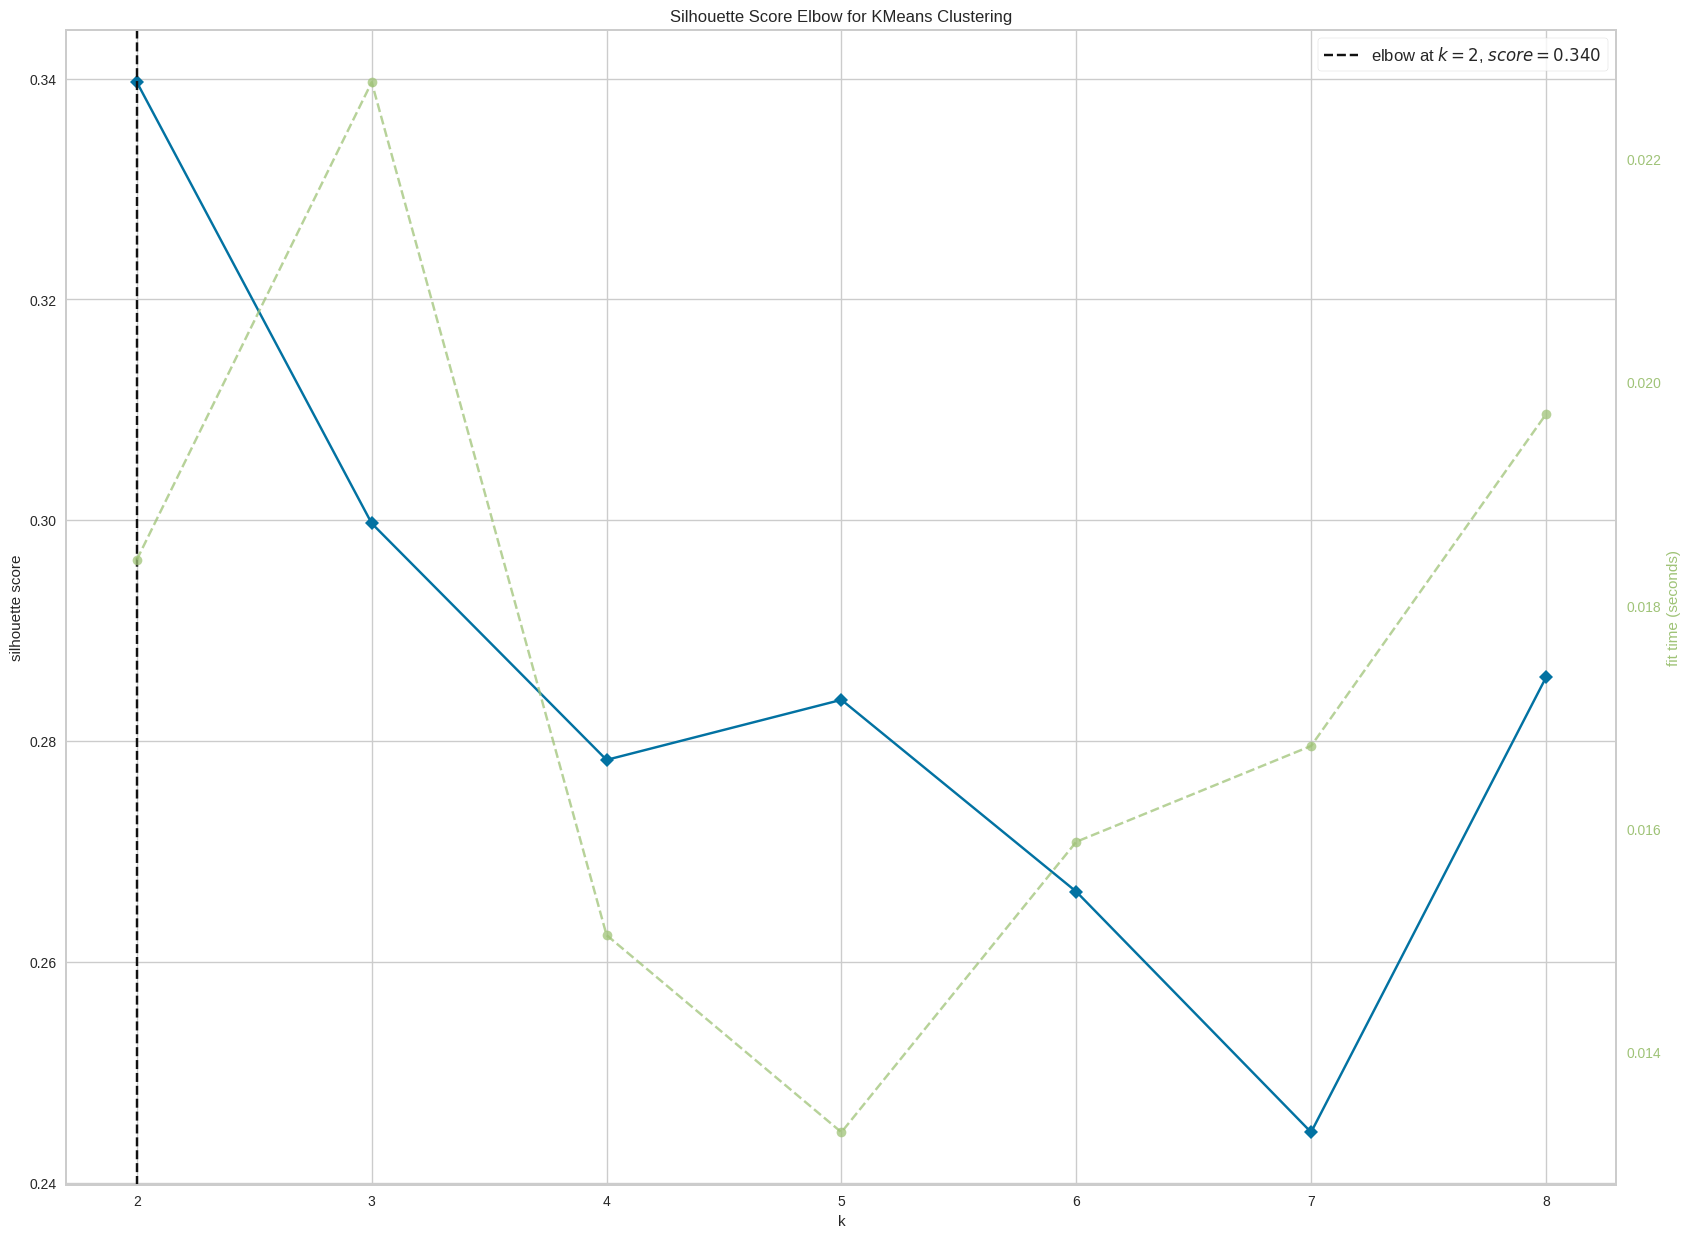

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [167]:
model = KMeans(random_state=40)
visualizer = KElbowVisualizer(model, k=(2,9), metric='silhouette', timings=True)
visualizer.fit(t)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

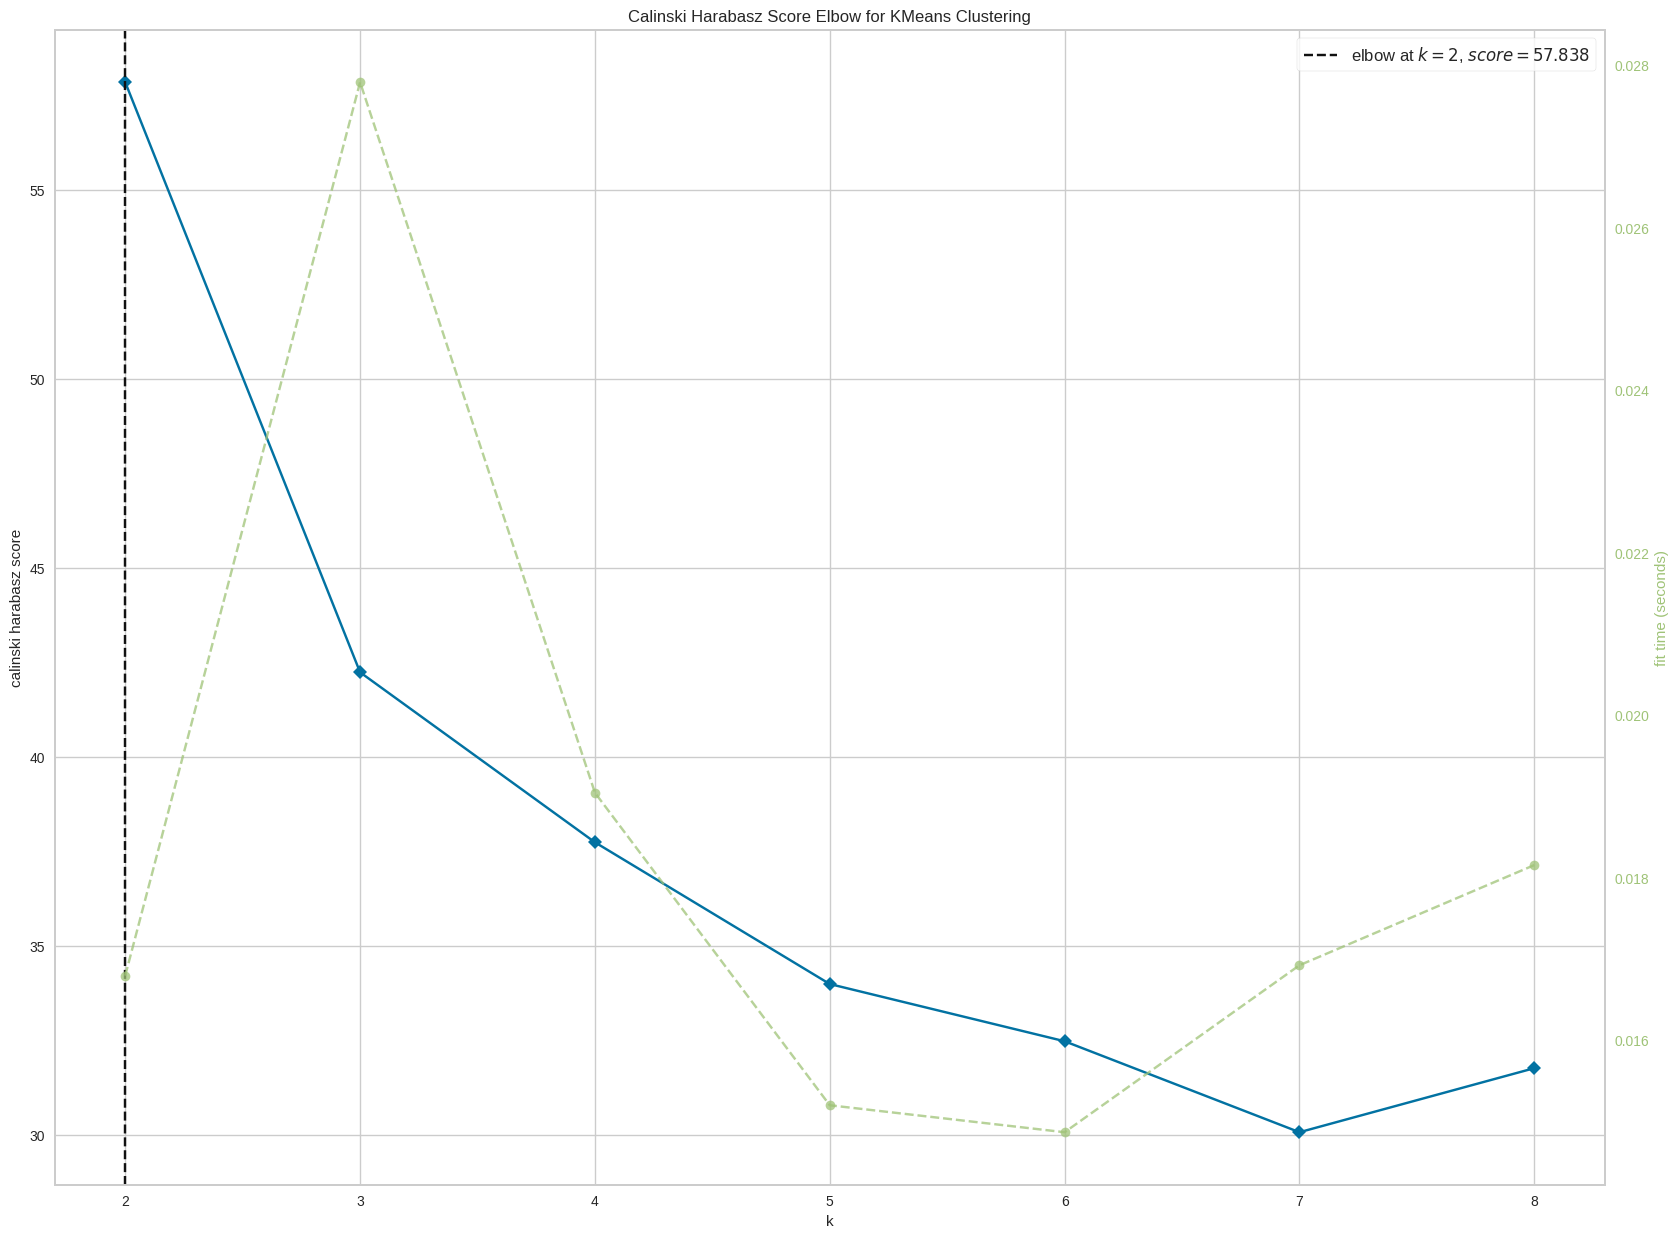

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [168]:
model = KMeans(random_state=40)
visualizer = KElbowVisualizer(model, k=(2,9), metric='calinski_harabasz', timings=True)
visualizer.fit(t)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [169]:
#K-means clustering

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(t)
data['cluster_num'] = kmeans.labels_ #adding to df
print (kmeans.labels_) #Label assigned for each data point
print (kmeans.inertia_) #gives within-cluster sum of squares.
print(kmeans.n_iter_) #number of iterations that k-means algorithm runs to get a minimum within-cluster sum of squares
print(kmeans.cluster_centers_) #Location of the centroids on each cluster.

[0 3 2 1 1 0 3 3 1 2 2 1 1 2 3 1 0 1 3 1 1 2 1 0 0 1 1 2 3 3 2 1 1 2 1 1 1
 3 3 2 0 1 2 1 1 1 1 0 0 3 2 0 1 1 2 1 1 3 1 0 3 2 2 2 3 0 1 2 3 2 1 2 0 2
 1 1 2 3 2 0 1 2 3 1 2 1 2 2 2 1 2 3 3 2 1 1 1 3 1 2 2 2 2]
427.887468451736
5
[[ 3.38081 -1.38223 -0.36489  0.10477  0.40601  0.27185  0.242   -0.10662
   0.04313]
 [-1.28035  0.15751 -0.8038   0.03883 -0.26171  0.05765 -0.02518 -0.04843
  -0.00967]
 [ 1.4734   0.75533  0.44439  0.22305  0.00588 -0.20901 -0.0464   0.13708
   0.00747]
 [-2.16662 -0.64972  1.15112 -0.52704  0.2495   0.04766 -0.03575 -0.0585
  -0.02224]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [170]:
#To see each cluster size

Counter(kmeans.labels_)

Counter({0: 13, 3: 19, 2: 32, 1: 39})

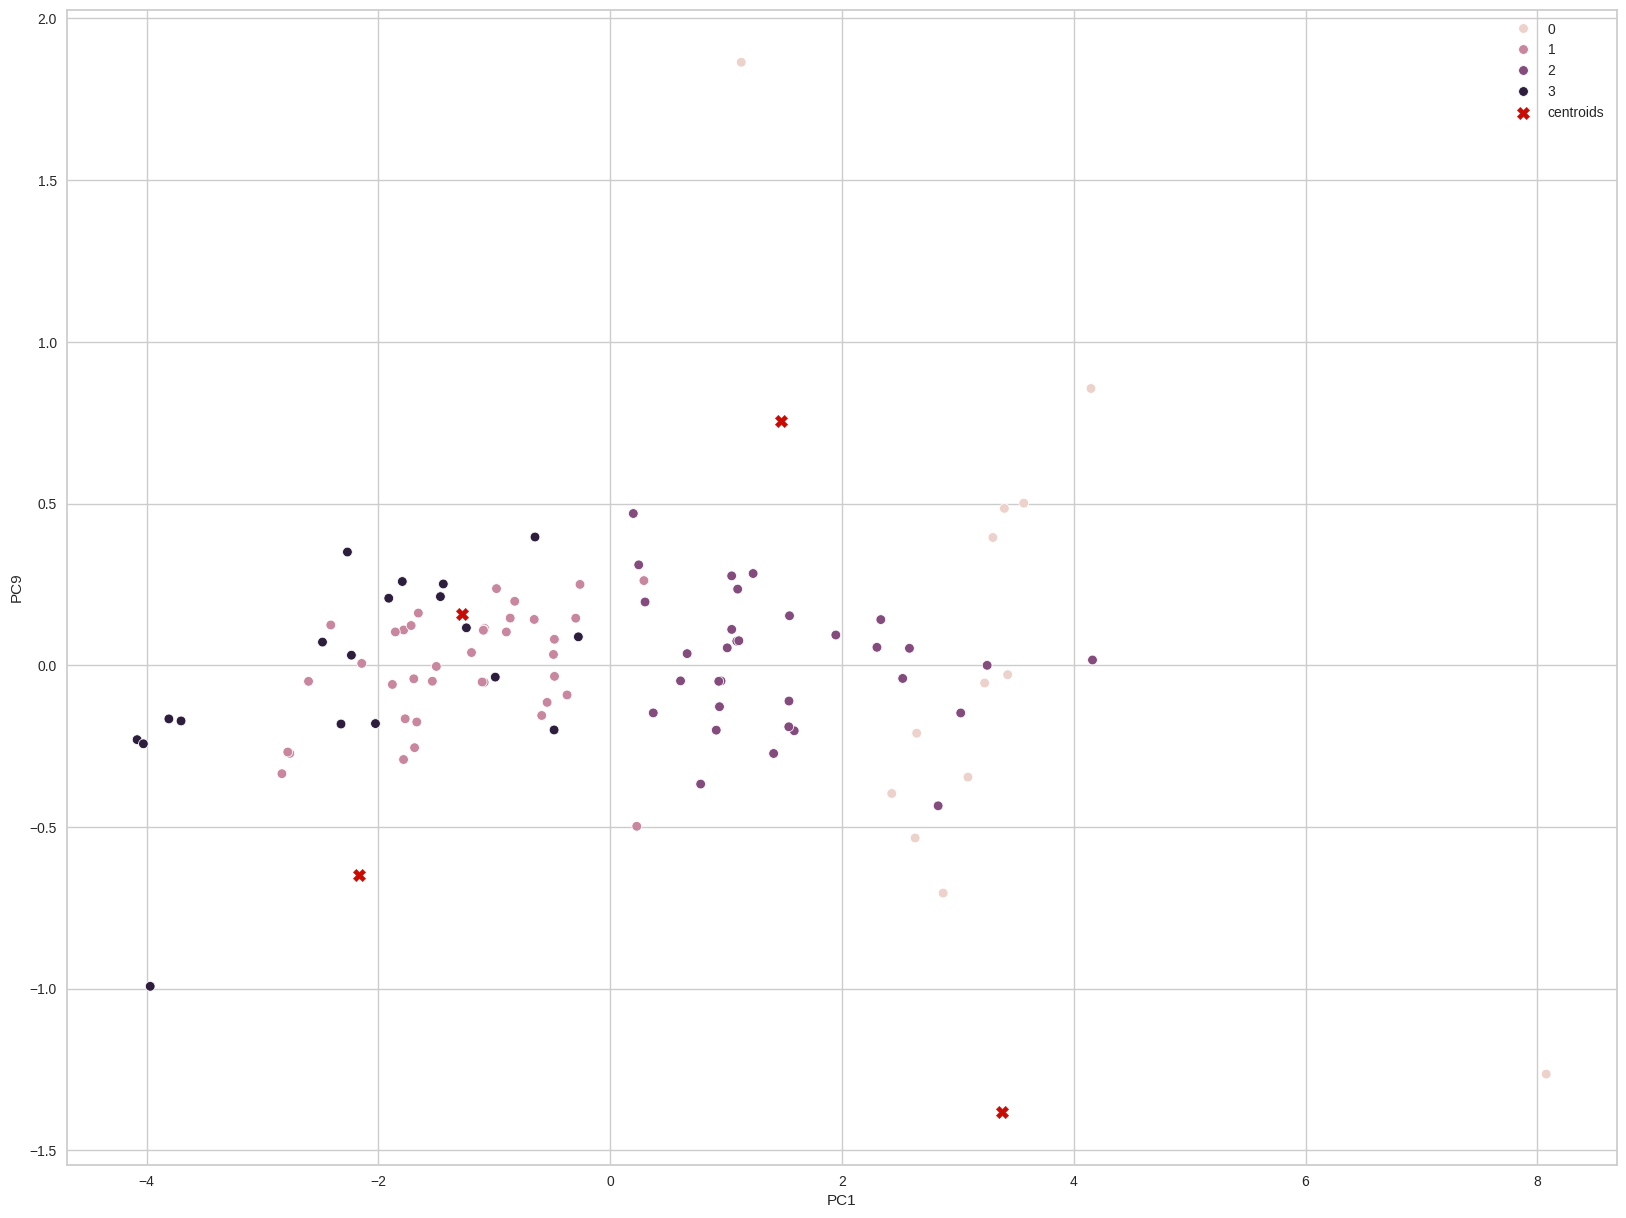

In [171]:
#Visulazing clusters
sb.scatterplot(data=data2, x="PC1", y="PC9", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
            marker="X", c="r", s=80, label="centroids")
plt.legend()
plt.show()

## Regression for data2

In [172]:
X=data2[['PC1', 'PC2','PC3','PC4','Pc5','PC6', 'PC7','PC8','PC9']]
y=data['inr(10e3)']

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.4, random_state=101)
lm=LinearRegression().fit(X_train,y_train)

In [174]:
print(lm.intercept_)

4643.522050485438


In [175]:
lm.coef_

array([ 1101.58721,  -741.20904,   208.53617,   508.32246,   122.3533 ,
        1579.00686,   333.61147, -1079.99512,  1461.72269])

In [176]:
X_train.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'Pc5', 'PC6', 'PC7', 'PC8', 'PC9'], dtype='object')

In [177]:
cdf=pd.DataFrame(lm.coef_, X.columns, columns=['Coeff'])
cdf

,Coeff
PC1,1101.5872
PC2,-741.2090
PC3,208.5362
PC4,508.3225
Pc5,122.3533
PC6,1579.0069
PC7,333.6115
PC8,-1079.9951
PC9,1461.7227


In [178]:
predictions=lm.predict(X_test)
predictions

array([ 3744.    ,  2496.    ,  5233.28  ,  3243.7184,  3064.8384,
        5459.584 ,  2903.68  ,  3328.    ,  3952.    ,  2594.5088,
        2654.08  ,  3744.    ,  2041.2288, 15040.9792,  6609.824 ,
        3170.336 ,  4451.2   ,  2866.9888,  3744.    , 17888.    ,
        4877.184 ,  5660.928 ,  5876.4992,  2062.528 , 12396.8   ,
        8565.024 , 12338.6432,  3328.    ,  4695.808 ,  5408.    ,
        3064.8384,  3120.    ,  2826.3872, 10400.    ,  2745.6   ,
        2912.    ,  3153.28  ,  5028.3584,  2424.9472,  2766.0672,
        5604.1856,  3098.1184])

In [179]:
y_test

37    3744.0000
1     2496.0000
69    5233.2800
80    3243.7184
92    3064.8384
61    5459.5840
85    2903.6800
53    3328.0000
88    3952.0000
32    2594.5088
6     2654.0800
71    3744.0000
43    2041.2288
16   15040.9792
50    6609.8240
31    3170.3360
97    4451.2000
14    2866.9888
25    3744.0000
51   17888.0000
21    4877.1840
3     5660.9280
84    5876.4992
57    2062.5280
48   12396.8000
47    8565.0240
79   12338.6432
58    3328.0000
2     4695.8080
13    5408.0000
45    3064.8384
89    3120.0000
41    2826.3872
23   10400.0000
26    2745.6000
22    2912.0000
94    3153.2800
27    5028.3584
20    2424.9472
66    2766.0672
30    5604.1856
35    3098.1184
Name: inr(10e3), dtype: float64

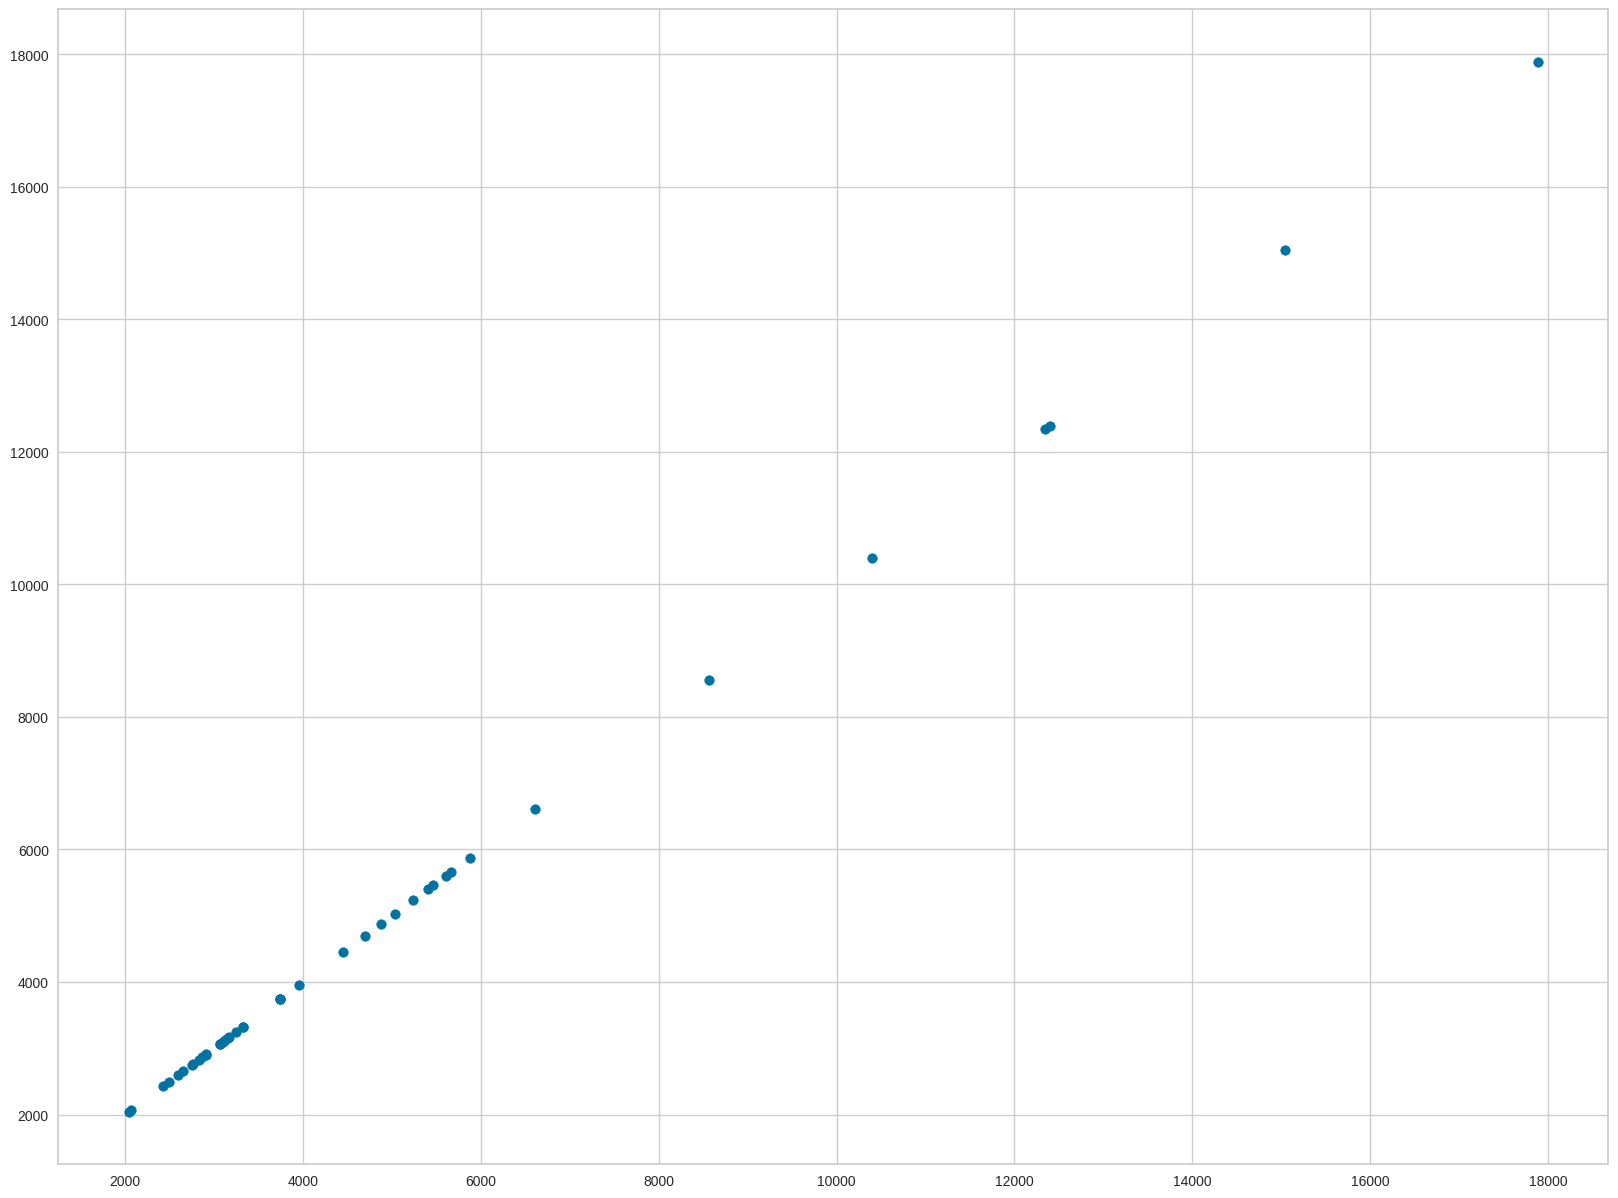

In [180]:
plt.scatter(y_test, predictions)

In [182]:
print('MAE:',metrics.mean_absolute_error(y_test,predictions))
print('MSE:',metrics.mean_squared_error(y_test,predictions))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,predictions)))

MAE: 2.2629094365540715e-12
MSE: 1.0768119045556378e-23
RMSE: 3.281481227366138e-12


In [183]:
metrics.mean_absolute_error(y_test,predictions)

2.2629094365540715e-12

In [184]:
metrics.mean_squared_error(y_test,predictions)

1.0768119045556378e-23

In [185]:
np.sqrt(metrics.mean_squared_error(y_test,predictions))

3.281481227366138e-12